# Textons



纹理图像是由重复的规则或随机pattern构成的一类特殊图像。纹理描述了物体的材质。纹理基元（texton）是描述纹理的一种有效方式，是纹理图像的bag-of-visual-words模型。本次作业实现2D纹理图像中的LM texton，是[原文](https://people.eecs.berkeley.edu/~malik/papers/LM-3dtexton.pdf)算法的简化。

## 数据集

我们使用[Brodatz数据集](https://sipi.usc.edu/database/database.php?volume=textures)的一部分来做实验。该部分数据和本笔记本一起发布，下载使用即可。这些图像都是单通道1024分辨率。在做分类和重构实验中，可以截取512或者256大小的子图像作为训练集和测试集。

/home/zdl/anaconda3/envs/torch1.12.1_cpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(tensor([[[0.8471, 0.8471, 0.8824,  ..., 0.7882, 0.8157, 0.8549],
         [0.8157, 0.8706, 0.9137,  ..., 0.7882, 0.8431, 0.8157],
         [0.8000, 0.8196, 0.8824,  ..., 0.8157, 0.8510, 0.8353],
         ...,
         [0.8235, 0.8000, 0.7882,  ..., 0.8471, 0.8549, 0.8157],
         [0.8275, 0.8196, 0.7922,  ..., 0.8314, 0.8118, 0.7961],
         [0.8157, 0.8275, 0.8039,  ..., 0.8431, 0.8118, 0.8118]]]), 11)
torch.Size([1, 256, 256])


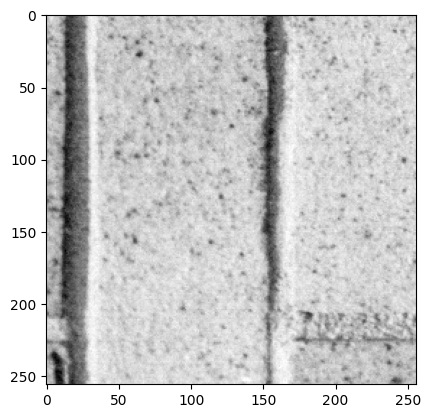

In [1]:
# 设计Brodatz数据集的Dataset类
# 使用1.3.01.tiff至1.3.13.tiff这13个纹理图像作为13个类别
# 但是在训练深度学习模型时，每类需要更多的图像，我们从每类中随机裁剪出100张256*256大小的子图像作为训练或者测试使用

import torch
from torch.utils.data import Dataset
import torchvision
from torchvision.io import read_image
import cv2 # 上面的read_image函数无法读取tiff图像

import os
import random

class BrodatzDataset(Dataset):
    def __init__(self, img_dir, num_per_class=10, transform=None):
        self.img_dir = img_dir
        self.num_per_class = num_per_class
        self.transform = transform
        self.img_files = [img_dir + '1.3.' + str(i).zfill(2) + '.tiff' for i in range(1, 14)]
        self.labels = []
        for img_file in self.img_files:
            label = os.path.basename(img_file).split('.')[0][-2:]
            self.labels.append(int(label)-1)
    
    def __len__(self):
        return self.num_per_class * 13
    
    def __getitem__(self, index):
        label = index // self.num_per_class
        # image = read_image(self.img_files[index]).float()
        image1024 = cv2.imread(self.img_files[label], -1)#.astype(np.float32)
        h, w = image1024.shape
        # image1024 = np.expand_dims(image1024, axis=0)
        x = random.randint(0, w - 256)
        y = random.randint(0, h - 256)
        image = image1024[y:y+256, x:x+256]        
        if self.transform:
            image = self.transform(image)        
        return image, label

training_dataset = BrodatzDataset(img_dir='./textures_2014/',
                  transform=torchvision.transforms.ToTensor())

# training_dataset中的每一个元素是一个个元组,元组的第一项是图像tensor,第二项是图像的类别. 每个图像tensor只有一个通道
# 有13个类别,标签label范围为0~12
# 每个类别可以获得100张随机选择的子图像,标签i的索引范围是[i*100,(i+1)*100),前闭后开
a_sample = training_dataset[119]   
print(a_sample)

print(a_sample[0].shape)  # the image, [C, H, W]
import matplotlib.pyplot as plt
plt.imshow(a_sample[0][0], cmap='gray')
plt.show()

In [2]:
199 // 100

1

## Texton

### LM filter bank

著名的牛津大学的VVG组提供了多种filter bank的[Matlab代码](https://www.robots.ox.ac.uk/~vgg/research/texclass/filters.html)。网上有人做了[Python的实现](https://github.com/tonyjo/LM_filter_bank_python)。这份代码有bug，输出结果和Matlab的不一致，我把这个仓库fork了一份，并修正了其中的bug，稍后会给原作者提PR。本次作业请使用我修改后的[Python代码](https://github.com/qilin512/LM_filter_bank_python/blob/master/lm.py)（我只修改了lm.py文件）。

输出的F矩阵（3维数组）包含了48个滤波器，每个都是49*49。

In [43]:
# 使用我修改后的代码构造filter bank
# 可以把相关的代码拷贝过来，或者把该Python文件加入到工程中，作为jupyter笔记本调用的外部程序。
from lm import makeLMfilters
import numpy as np

F = makeLMfilters()
print(F.shape)
print(F.dtype)

# plt.imshow(F[:,:,30], cmap='gray')
# plt.show()

(49, 49, 48)
float64


### 基于滤波器响应的纹理图像分类

使用filter bank对图像进行滤波，每个图像产生C个特征图（假设滤波器个数为C）。计算每个特征图的均值和方差，得到元素个数为2C的特征向量。使用KNN算法在特征向量的基础上对图像进行分类。scikit库里有个使用Garbor filters进行纹理分类的[例子](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_gabor.html)，有一点相似的地方，可以参考。

In [4]:
from lm import makeLMfilters
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import torchvision
import torchvision.transforms as trans
import cv2
import torch

## 使用特征图的简单统计特征（均值和方差）对图像进行分类

#将图像与kernel做卷积,将卷积操作后的特征图的均值和方差作为特征
def compute_feats(img, kernels):
    feats = np.zeros((kernels.shape[2], 2), dtype=np.float64)
    for k in range(kernels.shape[2]):
        filtered = ndi.convolve(img, kernels[:,:,k], mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats

images = []
labels = []
for i, item in enumerate(training_dataset):
    images.append(item[0][0])  #item[0]指每个元素中所包含的图像,因为数据是单通道的,所以直接取第一个通道
    labels.append(item[1])     #item[1]就对应每个图像的标签

#prepare filter bank kernels
kernels = makeLMfilters()
#类别数
class_num = 13
#filter个数
filter_num = kernels.shape[2]

#prepare reference features (ref_feats的shape为(训练集中的图像个数, filter_num, 2))
ref_feats = np.zeros((len(images), filter_num, 2), dtype=np.float32)
for i in range(len(images)):
    ref_feats[i, :, :] = compute_feats(images[i], kernels)

In [5]:
#test
img_dir='./textures_2014/'
transform = trans.Compose([trans.ToTensor(),trans.Resize(256)])
testset = [img_dir + '1.4.' + str(i).zfill(2) + '.tiff' for i in range(1, 13)]
img_test = [transform(cv2.imread(i, -1)) for i in testset] 
#img_test是个列表,列表中的每个元素是一个单通道图像,每个元素的shape为torch.Size([1, 256, 256])
print(len(img_test), img_test[0].shape)

ref_feats_test = np.zeros((len(img_test), filter_num, 2), dtype=np.float32)
for i in range(len(img_test)):
    ref_feats_test[i, :, :] = compute_feats(img_test[i][0], kernels)
print(ref_feats_test.shape)

12 torch.Size([1, 256, 256])
(12, 48, 2)


In [6]:
from clustering import KNN
#num_per_class代表每个类别下的图像个数(可修改)
num_per_class = 10

#把ref_feats变成二维的
X = torch.tensor(np.reshape(ref_feats, (ref_feats.shape[0], -1)))
y = torch.tensor([x // num_per_class for x in range(X.shape[0])])
X_test = torch.tensor(np.reshape(ref_feats_test, (ref_feats_test.shape[0], -1)))

print(X.shape, X_test.shape)
knn = KNN(X, y)  #默认k为3
y_ = knn(X_test)
print(y_)

torch.Size([130, 96]) torch.Size([12, 96])
tensor([ 4,  4,  4,  3,  4,  4,  4,  4,  4,  3, 12,  1])


### 生成textons

使用LM filter bank对纹理图像进行滤波，并生成Texton。具体地，针对一幅纹理图像（比如$H\times W$大小），使用filter bank进行滤波（滤波器个数为C），得到$H \times W \times C$的特征图。每个像素对应一个C维的特征向量。针对这$H \times W$个特征向量进行K-means聚类，设置聚类类别数K=20。这K个聚类中心即称为该纹理图像的Texton。这种算法是稀疏编码在纹理图像上的应用，对应着bag-of-words模型里的字典。

In [7]:
# 你的实现代码
from kmeans_pytorch import kmeans, kmeans_predict

def filter_bank(img, kernels):
    feats = np.zeros((kernels.shape[2], H, W), dtype=np.float64)
    for k in range(kernels.shape[2]):
        filtered = ndi.convolve(img, kernels[:,:,k], mode='wrap')
        feats[k] = filtered
    return feats

one_img = a_sample[0][0]   #取第一个类别的一张图像
H, W = one_img.shape
feats = filter_bank(one_img, F)  #C * H * W
print(feats.shape)

(48, 256, 256)


In [8]:
hw = []
for i in range(H):
    for j in range(W):
        hw.append(feats[:, i, j])
hw = torch.tensor(np.array(hw))
print(hw.shape)

device = torch.device('cpu')
cluster_ids_hw, cluster_centers = kmeans(X=hw, num_clusters=20, distance='euclidean', device=device, tqdm_flag=False)
print(cluster_ids_hw.shape, cluster_centers.shape)
# print(cluster_centers)

torch.Size([65536, 48])
torch.Size([65536]) torch.Size([20, 48])


### 基于texton的纹理分类

如果做纹理分类任务，将数据集中的所有纹理图像都进行上述处理，每个图像都产生K个texton。所有图像的texton放在一起，再按距离把相似的texton进行合并（这一步可选），最终得到Q个texton。这样，每个图像的每个像素属于哪个texton是可追溯的，能得到一幅或者一类图像在这Q个textons上的频率分布（直方图）。在推断的时候，给定一幅纹理图像，滤波后，每个像素对应的特征向量和Q个texton计算距离，每个像素都会对应一个texton，从而获得该图像在Q个texton上的分布直方图。将该直方图和训练集中的每类对应的直方图计算卡方距离（$\chi^2$ distance），即能进行分类。

In [9]:
# 分类任务

## 构建texton database, 每个类别一张图像
transform = trans.Compose([trans.ToTensor(),trans.Resize(256)])
train_dataset_path = [img_dir + '1.3.' + str(i).zfill(2) + '.tiff' for i in range(1, 14)]
train_dataset = [transform(cv2.imread(i, -1)) for i in train_dataset_path] 
train_dataset = [item[0] for item in train_dataset]
texton_database = []
for img in train_dataset:
    H, W = img.shape
    feats = filter_bank(img, F)
    hw = []
    for i in range(H):
        for j in range(W):
            hw.append(feats[:, i, j])
    hw = torch.tensor(np.array(hw))
    device = torch.device('cpu')
    _, cluster_centers = kmeans(X=hw, num_clusters=20, distance='euclidean', device=device, tqdm_flag=False)
    texton_database.append(cluster_centers)
texton_databases = torch.stack(texton_database, 0)  #shape(13, k in kmeans, 48)

In [10]:
textons = texton_databases.view(-1, texton_databases.shape[2]) #把第一维和第二维合并,torch.Size([260, 48])
print(textons.shape)

torch.Size([260, 48])


In [11]:
## 获得训练集中每个类别的图像在texton_databases上的分布直方图
trainset_hist = []
for img in train_dataset:
    H, W = img.shape
    feats = filter_bank(img, F)
    hw = []
    for i in range(H):
        for j in range(W):
            hw.append(feats[:, i, j])
    hw = torch.tensor(np.array(hw))
    label_t = []
    for pixel in hw:
        tmp = torch.sum((pixel - textons) ** 2, dim=1)
        label_t.append(torch.argmin(tmp))
    label_t = torch.FloatTensor(label_t)
    hist = torch.histc(label_t, bins=textons.shape[0])
    trainset_hist.append(hist)

13


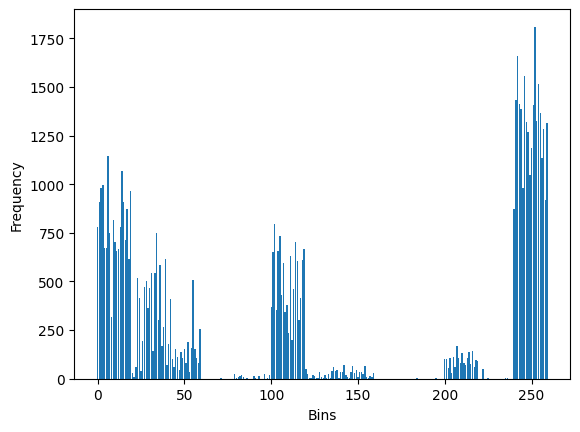

In [12]:
print(len(trainset_hist))
#可视化训练集中其中一张图像在texton_databases上的直方图分布
plt.bar(range(textons.shape[0]), trainset_hist[12], align='center')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.show()

In [13]:
## inference
example = transform(cv2.imread('./textures_2014/1.4.01.tiff', -1))[0] #取一张图像

example_feats = filter_bank(example, F)
print(example_feats.shape)
H, W = example.shape
example_hw = []
for i in range(H):
    for j in range(W):
        example_hw.append(example_feats[:, i, j])
example_hw = torch.tensor(np.array(example_hw))
print(example_hw.shape)

(48, 256, 256)
torch.Size([65536, 48])


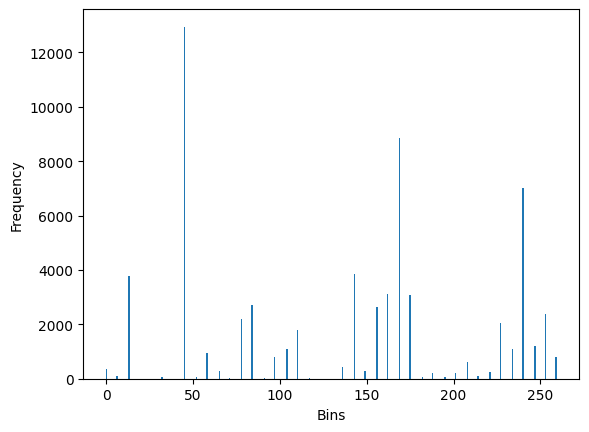

In [14]:
label_ = []
for pixel in example_hw:
    tmp = torch.sum((pixel - textons) ** 2, dim=1)
    label_.append(torch.argmin(tmp))
label_ = torch.FloatTensor(label_)

hist = torch.histc(label_, bins=textons.shape[0])

x = range(textons.shape[0])
plt.bar(x, hist, align='center')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.show()

In [15]:
#将从测试集中抽取的那张图像对应的直方图与每类对应的直方图计算卡方距离
predict_ = None  
min_dist = np.inf

for idx, item in enumerate(trainset_hist):
    cmp = cv2.compareHist(np.array(hist), np.array(item), method=cv2.HISTCMP_CHISQR)
    if cmp < min_dist: #找到距离最小的直方图,并记录其标签
        predict_ = idx
        min_dist = cmp
print('label:' + str(predict_))

label:7


### 基于texton的纹理重建

输入：一幅纹理图像、按照上述方法对这幅图像构建的texton字典。

目标：利用texton重构该图像。

算法：

1. 计算滤波器矩阵的伪逆。将F矩阵里的每个滤波器都拉成一个向量，C个滤波器构成一个新的F矩阵（$HW \times C$），求这个矩阵的伪逆$F^+$。
2. 每个texton都与$F^+$相乘，得到每个texton对应的重构patch。根据原图像的每个像素值对应的texton，找到对应的重构patch，将该patch的中心元素作为重构图像的该像素的像素值。

In [44]:
# 重构任务的代码
import numpy as np

## 计算伪逆F+
F_ = np.reshape(F, (-1, F.shape[2])) #shape:(2401, 48)
pseudo_F_ = np.linalg.pinv(F_)  #shape:(48, 2401)

## 选择一张纹理图像,构造其texton字典
sample = transform(cv2.imread('./textures_2014/1.4.01.tiff', -1))[0]
feats_sample = filter_bank(sample, F)
hw_sample = []
H, W = sample.shape
for i in range(H):
    for j in range(W):
        hw_sample.append(feats_sample[:, i, j])
hw_sample = torch.tensor(np.array(hw_sample))
device = torch.device('cpu')
_, textons_sample = kmeans(X=hw_sample, num_clusters=20, distance='euclidean', device=device, tqdm_flag=False)

In [45]:
print(textons_sample.shape)  #torch.Size([20, 48])
## 将每个texton与F+相乘,得到每个texton对应的重构patch
restruct_patch = textons_sample @ pseudo_F_
print(restruct_patch.shape)

torch.Size([20, 48])
torch.Size([20, 2401])


In [46]:
## 找到原图像每个像素对应的texton
print(hw_sample.shape)  # torch.Size([65536, 48])
label_sample = []
for pixel in hw_sample:
    tmp = torch.sum((pixel - textons_sample) ** 2, dim=1)
    label_sample.append(torch.argmin(tmp))
label_sample = torch.tensor(label_sample)
print(label_sample.shape, torch.min(label_sample), torch.max(label_sample))

torch.Size([65536, 48])
torch.Size([65536]) tensor(0) tensor(19)


In [47]:
## 根据每个像素对应的texton,找到对应的重构patch
hw_patch = restruct_patch[label_sample] #torch.Size([65536, 2401])
pixel_patch = hw_patch.view(H, W, -1)
restruct_img = pixel_patch[:,:,pixel_patch.shape[2] // 2]
print(restruct_img.shape)

torch.Size([256, 256])


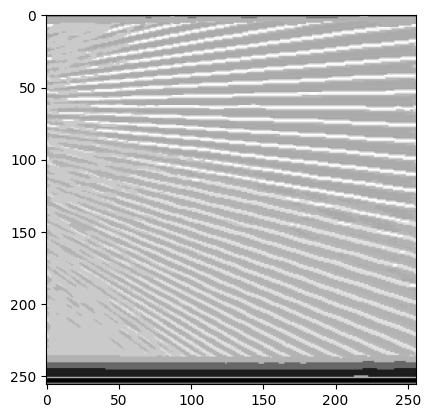

In [48]:
## 可视化重构的图像
plt.imshow(restruct_img, 'gray')
plt.show()

## 可学习的特征

filter bank设计得很巧妙，是学者的脑力贡献，如何运用filter bank提取的丰富特征？我们前面用过统计特征（均值和方差）和texton（聚类pooling）。如果能从数据中学习到参数，岂不是更好？最后让我们借鉴深度学习里的CNN（convolutional neural network）。

请设计一个两层的CNN网络，第一个卷积层设置为我们的filter bank：48个卷积核（滤波器），大小为$49 \times 49$（够大核的）。第二层卷积层的卷积核个数为类别数，大小为$1 \times 1$。网络的第三层为global average pooling层(GAP层)。最后接softmax输出类别概率。

第一层卷积层因为使用设计好的filter bank，所以需要加载现成的参数，相当于预训练的部分模型参数。

实验分两部分。第一部分实验freeze第一个卷积层，只学习第二个卷积层。第二部分实验学习网络的全部参数，相当于对filter bank进行微调fine tuning。对比一下两个部分的分类效果，并把第二部分的微调后的第一个卷积层的滤波器保存并可视化出来，看看和学者们设计的滤波器相比有什么变化。

In [49]:
# 华为智能基座吗？
# import mindspore as torch

# 下面这个示例是关于如何修改网络参数以及固定网络参数不更新

import numpy as np
import torch
from torch import nn

class TextonNet(nn.Module):
    def __init__(self):
        super(TextonNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, padding=1, bias=False)
        self.fc1 = nn.Linear(2, 3)
    def forward(self, x):
        out = self.conv1(x)
        out = self.fc1(out)
        return out

model = TextonNet()
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param} \n")

# 修改模型的某个参数，参考这个实现加载LM filter bank
with torch.no_grad():
    # 修改全连接层矩阵里的某个元素的值
    model.fc1.weight[0][0] = 99
    # 修改卷积层里的两个滤波器为Sobel算子
    model.conv1.weight[0][0] = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    model.conv1.weight[1][0] = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param} \n")


Model structure: TextonNet(
  (conv1): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (fc1): Linear(in_features=2, out_features=3, bias=True)
)


Layer: conv1.weight | Size: torch.Size([2, 1, 3, 3]) | Values : Parameter containing:
tensor([[[[ 0.1971,  0.1770,  0.2538],
          [-0.2600,  0.1314, -0.0883],
          [-0.2241, -0.1893, -0.1552]]],


        [[[ 0.1970,  0.2393,  0.2409],
          [-0.0890,  0.0275, -0.1880],
          [ 0.0023, -0.1093, -0.0864]]]], requires_grad=True) 

Layer: fc1.weight | Size: torch.Size([3, 2]) | Values : Parameter containing:
tensor([[ 0.6108,  0.6349],
        [ 0.2438, -0.1798],
        [-0.3706, -0.3187]], requires_grad=True) 

Layer: fc1.bias | Size: torch.Size([3]) | Values : Parameter containing:
tensor([ 0.7019,  0.4354, -0.2013], requires_grad=True) 

Layer: conv1.weight | Size: torch.Size([2, 1, 3, 3]) | Values : Parameter containing:
tensor([[[[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0

### 冻结模型参数

In [50]:
# 获取模型的参数，有state_dict和parameters（named_parameters)两种方法，
# 除了返回类型不同外，更重要的是参数的requires_grad属性的区别。
# 尤其是需要把某些参数freeze，使其不在学习过程中更新


# 方法1：直接修改参数的"requires_grad"值
model.fc1.weight.requires_grad = False

# 方法2：通过parameters()或named_parameter()函数返回的生成器(generator)来修改
for name, param in model.named_parameters():
    if name == 'conv1.weight':
        param.requires_grad = False

for name, param in model.named_parameters():
    print(f'{name}, {param.requires_grad}')
print('\n')

# 如何验证修改成功了呢？
# 这时需要使用parameters()或者named_parameters()函数提取参数，然后输出其requires_grad属性查看。
# 因为模型训练时，是把模型的parameters()传给优化器，而不是state_dict。

# 错误的方法：通过state_dict来修改
# 这种做法无法在反向传播时冻结参数
# state_dict提取的模型参数的requires_grad默认都是False
# 比如直接输出fc1.bias的requires_grad属性，结果为False
print("state_dict['fc1.bias'].requires_grad is ")
print(model.state_dict()['fc1.bias'].requires_grad)

# 下面的代码，使用state_dict将fc1.bias的requires_grad修改为False，
# 通过state_dict的方式再次验证，其值也是False，
# 但是通过named_parameters()方法查看其requires_grad属性，结果还是True
model.state_dict()['fc1.bias'] = False
print("state_dict['fc1.bias'].requires_grad is ")
print(model.state_dict()['fc1.bias'].requires_grad)
for name, param in model.named_parameters():
    print(f'{name}, {param.requires_grad}')
print('\n')
# PyTorch这样设计是因为考虑到使用state_dict提取模型参数时通常会做一些修改，
# 如果这些修改使用了某些影响梯度跟踪的运算，当requires_grad默认是True时会影响该参数的梯度计算。

# 网上有人提到用下面这种方法也是错误的。
tmp_state_dict = model.state_dict()
tmp_state_dict['fc1.bias'].requires_grad = False
model.load_state_dict(tmp_state_dict)
for name, param in model.named_parameters():
    print(f'{name}, {param.requires_grad}')
print('\n')

conv1.weight, False
fc1.weight, False
fc1.bias, True


state_dict['fc1.bias'].requires_grad is 
False
state_dict['fc1.bias'].requires_grad is 
False
conv1.weight, False
fc1.weight, False
fc1.bias, True


conv1.weight, False
fc1.weight, False
fc1.bias, True




如果微调后的滤波器分类效果更好的话，可否用在重构任务上？重构的效果会不会更好？如果重构效果更好的话，可否用深度网络实现重构任务？

In [77]:
## 设计一个含两层卷积层的CNN网络
import numpy as np
import torch
from torch import nn

class TextonNet(nn.Module):
    def __init__(self):
        super(TextonNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=48, kernel_size=49, padding=24, bias=False)
        self.conv2 = nn.Conv2d(in_channels=48, out_channels=13, kernel_size=1)
        self.gap = nn.AdaptiveAvgPool2d((1,1))
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.gap(out)
        out = out.view(out.size(0), out.size(1))
        return nn.functional.softmax(out, dim=-1)
model = TextonNet()

In [78]:
## 对第一层卷积层加载LM filter bank
filters = makeLMfilters()
print(model.conv1.weight.shape) # torch.Size([48, 1, 49, 49])
print(filters.shape)  #shape:(49, 49, 48)

with torch.no_grad():
    for i in range(filters.shape[2]):
        model.conv1.weight[i][0] = torch.tensor(filters[:,:,i])

torch.Size([48, 1, 49, 49])
(49, 49, 48)


In [98]:
## 第一部分实验:freeze第一个卷积层,只学习第二个卷积层
model.conv1.weight.requires_grad = False

# 训练集
transform = trans.Compose([trans.ToTensor(),trans.Resize(256)])
train_dataset_path = [img_dir + '1.3.' + str(i).zfill(2) + '.tiff' for i in range(1, 14)]
train_dataset = [transform(cv2.imread(i, -1)) for i in train_dataset_path] 
train_dataset = [item[0] for item in train_dataset]
trainset = torch.stack(train_dataset, dim=0)
trainset = trainset.unsqueeze(dim=1) #Size([B, C, H, W])

# 训练
max_epoch = 10
epoch = 0
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                            lr = 0.1, betas=(0.9, 0.999))
while epoch < max_epoch:
    print(f'Epoch {epoch}')
    
    data = trainset
    label = torch.tensor(np.array(range(trainset.shape[0])))
    data = data.detach()
    label = label.detach()

    cla = model(data)
    loss_cla = loss_fn(cla, label)
    loss = loss_cla

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'loss: {loss} at epoch: {epoch}')
    epoch += 1

Epoch 0
loss: 2.5308146476745605 at epoch: 0
Epoch 1
loss: 2.528944730758667 at epoch: 1
Epoch 2
loss: 2.527146339416504 at epoch: 2
Epoch 3
loss: 2.5254220962524414 at epoch: 3
Epoch 4
loss: 2.523768901824951 at epoch: 4
Epoch 5
loss: 2.5221800804138184 at epoch: 5
Epoch 6
loss: 2.5206568241119385 at epoch: 6
Epoch 7
loss: 2.5191996097564697 at epoch: 7
Epoch 8
loss: 2.5178072452545166 at epoch: 8
Epoch 9
loss: 2.516474485397339 at epoch: 9


In [100]:
# 测试
test_img = transform(cv2.imread('./textures_2014/1.4.01.tiff', -1))
test_img = test_img.unsqueeze(dim=0)

model.eval()

with torch.no_grad():
    output = model(test_img)
    test_img_pre = int(torch.argmax(output))
    print('label:' + str(test_img_pre))

label:3


In [101]:
## 第二部分实验:不再freeze第一个卷积层,学习网络的全部参数
model2 = TextonNet()

## 对第一层卷积层加载LM filter bank
filters = makeLMfilters()
print(model2.conv1.weight.shape) # torch.Size([48, 1, 49, 49])
print(filters.shape)  #shape:(49, 49, 48)

with torch.no_grad():
    for i in range(filters.shape[2]):
        model2.conv1.weight[i][0] = torch.tensor(filters[:,:,i])

# 训练
max_epoch = 10
epoch = 0
loss_fn2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                            lr = 0.1, betas=(0.9, 0.999))
while epoch < max_epoch:
    print(f'Epoch {epoch}')
    
    data = trainset
    label = torch.tensor(np.array(range(trainset.shape[0])))
    data = data.detach()
    label = label.detach()

    cla = model2(data)
    loss_cla = loss_fn(cla, label)
    loss = loss_cla

    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()

    print(f'loss: {loss} at epoch: {epoch}')
    epoch += 1

torch.Size([48, 1, 49, 49])
(49, 49, 48)
Epoch 0
loss: 2.5649876594543457 at epoch: 0
Epoch 1
loss: 2.5649876594543457 at epoch: 1
Epoch 2
loss: 2.5649876594543457 at epoch: 2
Epoch 3
loss: 2.5649876594543457 at epoch: 3
Epoch 4
loss: 2.5649876594543457 at epoch: 4
Epoch 5
loss: 2.5649876594543457 at epoch: 5
Epoch 6
loss: 2.5649876594543457 at epoch: 6
Epoch 7
loss: 2.5649876594543457 at epoch: 7
Epoch 8
loss: 2.5649876594543457 at epoch: 8
Epoch 9
loss: 2.5649876594543457 at epoch: 9


In [102]:
# 测试
test_img = transform(cv2.imread('./textures_2014/1.4.01.tiff', -1))
test_img = test_img.unsqueeze(dim=0)

model2.eval()

with torch.no_grad():
    output = model2(test_img)
    test_img_pre = int(torch.argmax(output))
    print('label:' + str(test_img_pre))

label:10


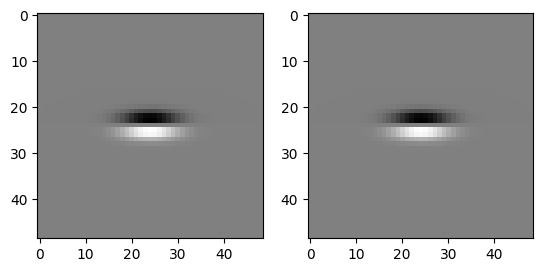

In [109]:
##对比微调前后的第一个卷积层上的滤波器

filter1 = model.conv1.weight[0][0].detach().numpy()
filter2 = model2.conv1.weight[0][0].detach().numpy()

plt.subplot(121)
plt.imshow(filter1, cmap='gray')
plt.subplot(122)
plt.imshow(filter2, cmap='gray')
plt.show()